## lib Loading

In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from si_prefix import si_format

## To Do list
- LS370 still crashes after around 7hrs continuous operation
- To better sync the T1256 and T8, we should ask py to generate below txt file
 - filename: CH1 T 18-11-19.txt
 - lines: 18-11-19,00:01:48,5.618350E+1

- Make new cables
    - Remake the I, V splitting Fisher probing line
    - Remake ISO, COM x2 Fisher-BNC cables
- Maintain old sample holder
    - Fix pin 5b
- Try to see if we can fix the wiring in the fridge. Currently ch 5ab open, ch 10ab short.
- Make new sample holder

## Update RTc for T8>102K

Locate files "CH8 T dd-mm-yy.log" and "CH0 T dd-mm-yy.log" under below path:

C:\Users\KelvinOX25\Documents\GitHub\measDC

Copy them to below path:

\\SERIN135_DR-PC\BlueFors\Temperature Log\dd-mm-yy

Then run below two cells

In [3]:
import time, datetime

def getTt(rootpath, filedate = '21-11-19', Tch = 0):
    filename = r'\\'+filedate+'\CH{} T '.format(Tch)+filedate+'.log'
    filepath = rootpath+filename

    dateori = datetime.datetime(2019,11,21,0,0,0)
    dhrslst = []
    dlst = []
    Tlst = []
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            l = line.strip()
            d = datetime.datetime(int(l.split(',')[0].split('-')[2])+2000,
                                  int(l.split(',')[0].split('-')[1]),
                                  int(l.split(',')[0].split('-')[0]),
                                  int(l.split(',')[1].split(':')[0]),
                                  int(l.split(',')[1].split(':')[1]),
                                  int(l.split(',')[1].split(':')[2]))
            T = float(l.split(',')[2])
            dhrslst.append(((d-dateori).days *86400 + (d-dateori).seconds)/60/60)
            dlst.append(d)
            Tlst.append(T)
            line = fp.readline()
            cnt += 1
    fp.close()
    return (dhrslst, dlst, Tlst)

def fillDataGap(ref_x1, gapped_x2, gapped_y2):
    filled_y2 = np.full_like(np.arange(len(ref_x1)),np.nan, dtype=np.double)
    for i,v2 in enumerate(gapped_x2):
        for j,v1 in enumerate(ref_x1):
            vt1 = v1.year*525600 + v1.month*43800 + v1.day*1440 + v1.hour*60 + v1.minute
            vt2 = v2.year*525600 + v2.month*43800 + v2.day*1440 + v2.hour*60 + v2.minute
            if vt2 == vt1:
                filled_y2[j]= gapped_y2[i]
                break
    return filled_y2

<IPython.core.display.Javascript object>


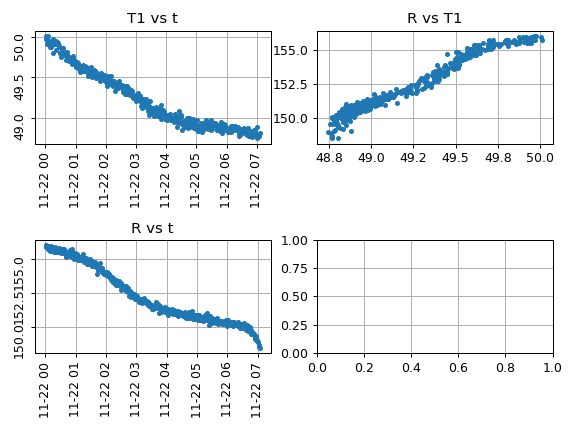

In [20]:
rootpath = r'\\SERIN135_DR-PC\BlueFors\Temperature Log'
filedate = '22-11-19'
dhrslst1, dlst1, Tlst1 = getTt(rootpath=rootpath, filedate = filedate, Tch = 1)
dhrslstR, dlstR, TlstR = getTt(rootpath=rootpath, filedate = filedate, Tch = 0)

TlstRnew = fillDataGap(ref_x1 = dlst1, gapped_x2 = dlstR, gapped_y2 = TlstR)
plt.close('all')
f,ax = plt.subplots(2,2)
ax[0][0].plot(dlst1,Tlst1,'.')
ax[0][0].set_title('T1 vs t')
ax[0][0].tick_params(labelrotation=90)

ax[1][0].plot(dlstR,TlstR,'.')
ax[1][0].set_title('R vs t')
ax[1][0].tick_params(labelrotation=90)

ax[0][1].plot(Tlst1,TlstRnew,'.')
from matplotlib.ticker import FormatStrFormatter
ax[0][1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0][1].set_title('R vs T1')


for i in [0,1]:
    for j in [0,1]:
        ax[i][j].grid()

plt.tight_layout()
plt.show()

## Realtime data visualization

In [2]:
import qcodes as qc
from qcodes.dataset.database import initialise_database
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


<IPython.core.display.Javascript object>


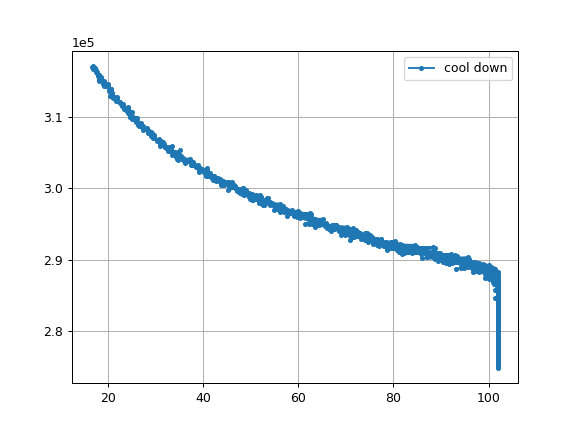

In [13]:
SAMPLE = 'aka5bN1'#site9 actually
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
label = ['cool down',
         'cool down',
         'warm up',
         'cool down',
         'warm up']

for i,v in enumerate([27]):#,32
    data = get_data_by_id(v)
    T = data[0][0]['data']
#     T = np.linspace(1,len(data[0][0]['data']),len(data[0][0]['data']))
    R = data[0][1]['data']

    ax.plot(T, R, '.',ls='-', label = label[i])# 

ax.legend()
ax.grid()
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

<IPython.core.display.Javascript object>


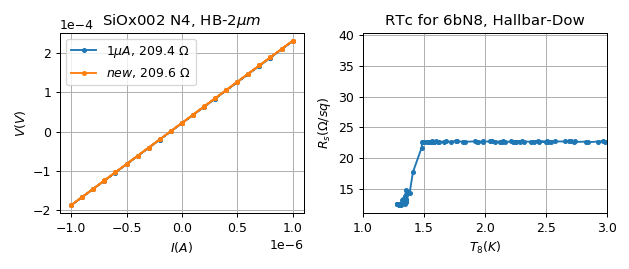

In [20]:
SAMPLE = 'O2N4' #1ab,1a2b
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 3.06e-6, 12.2e-6, 48e-9

labelL = ['$1\mu A$',
          '$new$']
for i,v in enumerate([8,11]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('SiOx002 N4, HB-$2\mu m$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelR = ['from 300K',#14,15,18,19
          'from 300K',
          'from 300K',
          'from 300K']
for i,v in enumerate([21]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.',ls='-', label = labelR[i])#ls='-', alpha=1-0.99*i 

# ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 6bN8, Hallbar-Dow')
ax[1].set_ylim(0,25)
ax[1].set_xlim(1,3)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()